# TP 1 – Architecture de fypy et courbes de taux

Dans ce premier TP, nous allons:
- comprendre la structure globale du package fypy;
- manipuler des courbes d'actualisation (DiscountCurve);
- relier taux continus, facteurs d'actualisation et prix à terme (EquityForward).

L'objectif est de poser les bases mathématiques (dérivations) **avant** de coder avec la librairie.

## 1. Vue d'ensemble de la librairie fypy

Le dossier principal `fypy` contient plusieurs sous-modules spécialisés:
- `model` : modèles sous-jacents (Black-Scholes, Lévy, Heston, etc.);
- `termstructures` : courbes de taux, courbes forward, dividendes;
- `volatility` : surfaces de volatilité, volatilité implicite;
- `pricing` : différents moteurs de pricing (analytique, Fourier, PDE, Monte Carlo...);
- `fit` et `calibrate` : calibration de modèles sur des données de marché;
- `market` : objets de marché (slices de volatilité, surfaces, etc.).

Dans ce TP, nous nous concentrons sur `termstructures`, car **tous les prix d'options** s'appuient sur des facteurs
d'actualisation et des forwards.

In [2]:
# Imports de base pour le TP
import numpy as np
import matplotlib.pyplot as plt

from fypy.termstructures.DiscountCurve import DiscountCurve_ConstRate, InterpolatedDiscountCurve
from fypy.termstructures.EquityForward import EquityForward

%matplotlib inline

/home/salok1/RepoFinal/FYPY/fypy/termstructures/DiscountCurve.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.interpolate import interp1d


## 2. Rappels de base : facteur d'actualisation et taux continu

### 2.1. Définition du facteur d'actualisation

On note \( D(T) \) le **facteur d'actualisation** à l'échéance \( T \):
- \( D(T) \) est la valeur **aujourd'hui** (date 0) d'un euro reçu à la date \( T \);
- en l'absence d'opportunités d'arbitrage, on peut toujours écrire \( D(T) \in (0,1] \) pour \( T>0 \).

Si le taux sans risque continu est constant et égal à \( r \), on a la relation bien connue:
\[
D(T) = e^{-r T}.
\]

La librairie fypy implémente cette idée via la classe `DiscountCurve_ConstRate`.

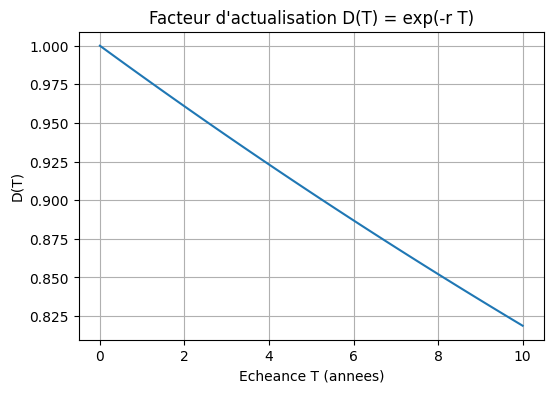

In [3]:
# Exemple 1 : courbe d'actualisation à taux constant
r = 0.02  # 2 pour cent en taux continu
disc_curve = DiscountCurve_ConstRate(rate=r)

T = np.linspace(0.0, 10.0, 100)
D_T = disc_curve(T)

plt.figure(figsize=(6, 4))
plt.plot(T, D_T)
plt.title('Facteur d\'actualisation D(T) = exp(-r T)')
plt.xlabel('Echeance T (annees)')
plt.ylabel('D(T)')
plt.grid(True)
plt.show()

### 2.2. Lien entre \( D(T) \) et le taux continu implécit

A partir d'une courbe quelconque \( T \mapsto D(T) \), on peut **déduire** un taux continu implécit \( r(T) \)
sur l'intervalle \([0,T]\):
\[
r(T) = -\frac{1}{T} \ln D(T).
\]

Démonstration:
1. on suppose qu'entre 0 et \( T \) le taux continu est constant et vaut \( r(T) \);
2. par définition, le facteur d'actualisation vaut alors \( D(T) = e^{-r(T) T} \);
3. on résout par rapport à \( r(T) \):
   - \( \ln D(T) = -r(T) T \);
   - \( r(T) = - \ln D(T) / T \).

C'est exactement ce que fait la méthode `implied_rate` de `DiscountCurve`.

In [4]:
# Illustration : retrouver le taux constant a partir de D(T)
T_test = np.array([0.5, 1.0, 5.0, 10.0])
r_implied = disc_curve.implied_rate(T_test)

for T_i, r_i in zip(T_test, r_implied):
    print('T =', T_i, 'ans  ->  taux implicite r(T) =', r_i)

print('\nTaux d\'entree r =', r)
print('On retrouve bien un taux constant, a des erreurs numeriques pres.')

T = 0.5 ans  ->  taux implicite r(T) = 0.02
T = 1.0 ans  ->  taux implicite r(T) = 0.02
T = 5.0 ans  ->  taux implicite r(T) = 0.02
T = 10.0 ans  ->  taux implicite r(T) = 0.02

Taux d'entree r = 0.02
On retrouve bien un taux constant, a des erreurs numeriques pres.


## 3. Prix a terme (forward) d'une action avec dividendes

On considère maintenant une action dont :
- le **spot** aujourd'hui est \( S_0 \);
- les flux de dividendes sont résument par un rendement continu \( q \) (modèle simple);
- le taux sans risque continu est \( r \).

### 3.1. Dérivation de la formule du forward

On cherche le prix forward \( F_0(T) \) d'achat à l'échéance \( T \). On raisonne par non-arbitrage :

1. Scénario A : on **achète au comptant** aujourd'hui.
   - on emprunte \( S_0 \) au taux \( r \);
   - on achète l'action et on reçoit les dividendes continus (rendement \( q \)).
2. Scénario B : on **prend un contrat forward** avec prix \( F_0(T) \).

En l'absence d'arbitrage, les positions A et B doivent avoir la même valeur à \( T \). On obtient la relation
classique:
\[
F_0(T) = S_0 e^{(r - q) T}.
\]

La librairie fypy implémente cette relation via `EquityForward.from_rates` et la méthode `fwd_T`.

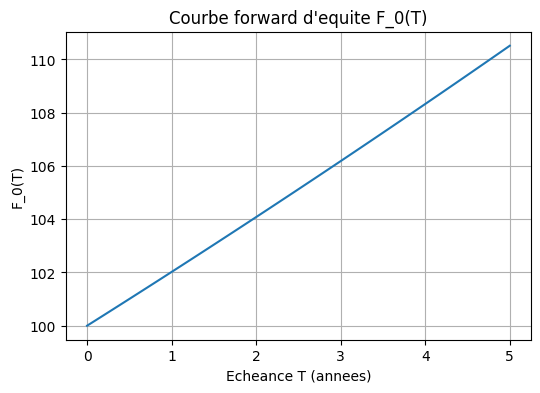

In [5]:
# Exemple 2 : construction d'une courbe forward d'equite
S0 = 100.0
r = 0.03   # taux sans risque
q = 0.01   # rendement du dividende

fwd_curve = EquityForward.from_rates(S0=S0, r=r, q=q)

T = np.linspace(0.0, 5.0, 50)
F_T = fwd_curve(T)

plt.figure(figsize=(6, 4))
plt.plot(T, F_T)
plt.title('Courbe forward d\'equite F_0(T)')
plt.xlabel('Echeance T (annees)')
plt.ylabel('F_0(T)')
plt.grid(True)
plt.show()

Vérifions numériquement que la formule théorique \( F_0(T) = S_0 e^{(r-q)T} \) est bien reproduite par fypy.

In [6]:
def forward_theorique(T, S0, r, q):
    return S0 * np.exp((r - q) * T)

T_test = np.array([0.5, 1.0, 2.0, 5.0])
F_lib = fwd_curve(T_test)
F_th = forward_theorique(T_test, S0, r, q)

for T_i, f_lib, f_th in zip(T_test, F_lib, F_th):
    print('T =', T_i, 'ans -> F_fypy =', f_lib, '  F_th =', f_th)

print('\nLes deux valeurs coincident a des erreurs numeriques pres.')

T = 0.5 ans -> F_fypy = 101.00501670841682   F_th = 101.00501670841679
T = 1.0 ans -> F_fypy = 102.02013400267558   F_th = 102.02013400267558
T = 2.0 ans -> F_fypy = 104.08107741923881   F_th = 104.08107741923882
T = 5.0 ans -> F_fypy = 110.51709180756477   F_th = 110.51709180756475

Les deux valeurs coincident a des erreurs numeriques pres.


## 4. Courbes d'actualisation interpolées

Dans la pratique, on ne dispose que d'un **nombre fini de points** sur la courbe \( T \mapsto D(T) \), par exemple
aux maturités \( T_1, \dots, T_n \). Il faut alors **interpoler** entre ces points.

fypy propose plusieurs approches via `InterpolatedDiscountCurve`:
- interpolation linéaire sur les discounts (from_linear);
- interpolation log-linéaire sur les discounts (from_log_linear), plus adaptée à des courbes de taux.

Dans ce TP, nous illustrons l'idée avec un exemple simple.

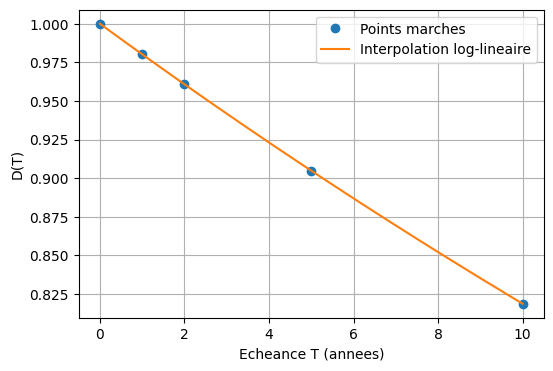

In [7]:
# Exemple 3 : construction d'une DiscountCurve a partir de points discrets
ttms = np.array([0.0, 1.0, 2.0, 5.0, 10.0])
discounts = np.exp(-0.02 * ttms)  # ici on simule une courbe constante a 2 pour cent

disc_interp = InterpolatedDiscountCurve.from_log_linear(ttms=ttms, discounts=discounts)

T_dense = np.linspace(0.0, 10.0, 200)
D_dense = disc_interp(T_dense)

plt.figure(figsize=(6, 4))
plt.plot(ttms, discounts, 'o', label='Points marches')
plt.plot(T_dense, D_dense, label='Interpolation log-lineaire')
plt.xlabel('Echeance T (annees)')
plt.ylabel('D(T)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Pour aller plus loin

A ce stade, vous devriez:
- savoir manipuler les objets de base `DiscountCurve` et `EquityForward`;
- comprendre le lien mathématique entre `D(T)`, taux continus et forwards;
- être prêt a connecter ces courbes a des modèles de prix d'options.

**Exercice propose** (pour s'entraîner) :
1. Modifier le profil de taux (par exemple, croissant puis decroissant) en changeant le vecteur `discounts`;
2. Construire la nouvelle `InterpolatedDiscountCurve`;
3. Observer l'effet sur les forwards d'equite `F_0(T)`;
4. Discuter comment cela se traduirait sur des prix d'options (intuition, sans coder pour l'instant).

Dans le TP suivant, nous utiliserons ces objets pour dériver et implémenter la formule de Black-Scholes,
puis la comparer a une simulation de Monte Carlo.